In [1]:
import pandas as pd
import numpy as np
import datetime 
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

pd.set_option('display.max_columns', 100)

# Introduction

In [39]:
# 2006 - 2017 raw data is taken from Stocker package which uses Quandl API
raw_data = pd.read_csv('./2012_2017_data.csv', index_col=0)

C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [40]:
raw_data.head(3)

,date,open,high,low,close,volume,ex-dividend,split ratio,adj. open,adj. high,adj. low,adj. close,adj. volume,ds,y,daily change,ticker
0,1998-05-20,15.25,15.25,15.00,15.00,21867.0,0.0,1.0,7.932029,7.932029,7.801996,7.801996,32800.5,1998-05-20,7.801996,-0.130033,MCBC
1,1998-05-21,15.25,15.25,14.88,15.00,23133.0,0.0,1.0,7.932029,7.932029,7.739580,7.801996,34699.5,1998-05-21,7.801996,-0.130033,MCBC
2,1998-05-22,15.00,15.25,15.00,15.19,1467.0,0.0,1.0,7.801996,7.932029,7.801996,7.900821,2200.5,1998-05-22,7.900821,0.098825,MCBC


In [3]:
# 2018 raw data is taken from yahoo-finance package
df_2018 = pd.read_csv('./2018_data.csv', index_col=0)

In [4]:
df_2018.head(3)

,Open,High,Low,Close,Adj Close,Volume,date,ticker
0,26.450001,27.10,26.34,27.030001,27.030001,275200,2018-01-03,PRO
0,31.160000,31.16,30.00,30.780001,30.780001,168000,2018-12-29,PRO
0,9.990000,10.13,9.95,10.000000,9.775415,67600,2018-01-03,MCBC


In [5]:
# narrowing data set to 2012 - 2017
# creating new column `year`
df_2012_2017 = (
    raw_data
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.date).dt.year))
    .query("year >= 2012")
    [['ticker', 'date', 'year', 'open', 'close']]
)

In [6]:
# getting the first day and last day of each year that is available in the data set
first_date_list = [df_2012_2017.query("year == '{}'".format(2012+i)).date.min() for i in range(6)]
last_date_list = [df_2012_2017.query("year == '{}'".format(2012+i)).date.max() for i in range(6)]
first_date_df =pd.DataFrame({"date": first_date_list}) 
last_date_df = pd.DataFrame({"date": last_date_list})

In [7]:
# filtering for the first day data in `df_2012_2017`
first_date_2012_2017_df = (
    df_2012_2017
    .merge(first_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=x.date.str[:4]))
    .rename(columns={"open": "open_first_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_first_day']]
    .pivot_table(values='open_first_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

# filtering last day data in `df_2012_2017` 
last_date_2012_2017_df = (
    df_2012_2017
    .merge(last_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=x.date.str[:4]))
    .rename(columns={"close": "close_last_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'close_last_day']]
    .pivot_table(values='close_last_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

In [8]:
# transforming 2018 data to be similar to the `first_date_2012_2017` and `last_date_2012_2017` dataframe
first_date_2018_df = (
    df_2018
    .query("date == '2018-01-03'")
    [['ticker', 'date', 'Open']]
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.date).dt.year))
    .rename(columns={"Open": "open_first_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_first_day']]
    .pivot_table(values='open_first_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

last_date_2018_df = (
    df_2018
    .query("date == '2018-12-29'")
    [['ticker', 'date', 'Close']]
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.date).dt.year))
    .rename(columns={"Close": "close_last_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'close_last_day']]
    .pivot_table(values='close_last_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)

In [9]:
# merging 2012-2017 data with 2018 data
agg_first_date_df = (
    first_date_2012_2017_df
    .merge(first_date_2018_df, on='ticker', how='inner')
    .rename(columns=({2018: "2018"}))
    .melt(id_vars='ticker', value_vars=['2012', '2013', '2014', '2015', '2016', '2017', '2018'])
    .rename(columns={"variable": "year", "value": "open_first_day"})
)

agg_last_date_df = (
    last_date_2012_2017_df
    .merge(last_date_2018_df, on='ticker', how='inner')
    .rename(columns=({2018: "2018"}))
    .melt(id_vars='ticker', value_vars=['2012', '2013', '2014', '2015', '2016', '2017', '2018'])
    .rename(columns={"variable": "year", "value": "close_last_day"})
)

In [10]:
# calculating yearly return and then averaging them to get average yearly returns for each stock
agg_gains_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    .groupby("ticker")
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "avg_yearly_returns"})
)

# calculating overall variance using each year's return
agg_var_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    [['ticker', 'gains_pctg']]
    .groupby("ticker")
    .agg(np.var)
    .reset_index()
    .rename(columns={"gains_pctg": "variance"})
)

agg_df3 = (
    agg_gains_df
    .merge(agg_var_df, on='ticker', how='inner')
)

In [11]:
agg_df3.head(3)

,ticker,avg_yearly_returns,variance
0,A,0.110970,0.060594
1,AAN,0.080143,0.048170
2,AAON,0.100059,0.079516


In [12]:
agg_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 0 to 1224
Data columns (total 3 columns):
ticker                1225 non-null object
avg_yearly_returns    1225 non-null float64
variance              1225 non-null float64
dtypes: float64(2), object(1)
memory usage: 38.3+ KB


In [13]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [14]:
def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    
    # robust scaling is used so that the centering and scaling statistics are therefore not influenced by a few number of very large marginal outliers as they are based on percentiles
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)

    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score After K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

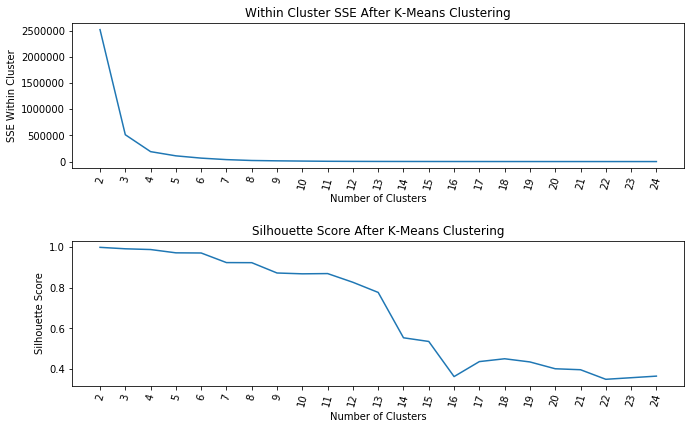

In [15]:
plot_cluster(agg_df3, max_loop=25)

From the first graph, `Within Cluster SSE After K-Means Clustering`, we can see that as the number of clusters increase pass 7, the sum of square of errors within clusters plateaus off. From the second graph, `Silhouette Score After K-Means Clustering`, we can see that there are various parts of the graph where a kink can be seen. Since there is not much a difference in SSE after 7 clusters and that the drop in sihouette score is quite significant between 13 clusters and 14 clusters, I would use 13 clusters in my K-Means model below.

In [16]:
def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        next
    X = df.iloc[:,1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10, n_jobs=-1)  
    kmeans.fit(X_rb) 
    score = metrics.silhouette_score(X_rb, kmeans.labels_, random_state=10)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score: " + str(score.round(2)))
    print("sse withing cluster: " + str(sse_within_cluster.round()))
    
    return df

In [17]:
first_trial = apply_cluster(agg_df3, clusters=13)

clustering performance
-----------------------------------
silhouette score: 0.78
sse withing cluster: 3014.0


In [18]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

cluster_perf_df

,cluster,avg_yearly_returns,variance,ticker
0,0,0.092591,0.110720,1123
1,11,0.345083,1.023035,57
2,8,0.546022,2.863663,21
3,12,0.789653,5.095783,10
4,6,1.046706,8.256837,4
5,10,1.315779,14.788991,2
6,5,1.850680,25.081983,2
7,9,2.420434,43.899749,1
8,3,3.340888,57.203435,1
9,7,3.562943,72.620209,1


From the dataframe above, we can see that the distribution of the stocks amongst the clusters is very skewed. Most of the stocks are aggregated in cluster `0`. For the other clusters, we can see that the `avg_yearly_returns` and `variance` are huge. A savvy investor would definitely not go for these other clusters as the variance is way too high, ranging from ~102% to 65100%. As such, he/she would most probably invest in a stock in cluster 0. As cluster 0 still contains too many stocks to choose from, I will attempt to conduct another K-Means clustering on cluster `0`.

In [19]:
agg_df3_sub = agg_df3.query("cluster == 0").reset_index(drop=True)

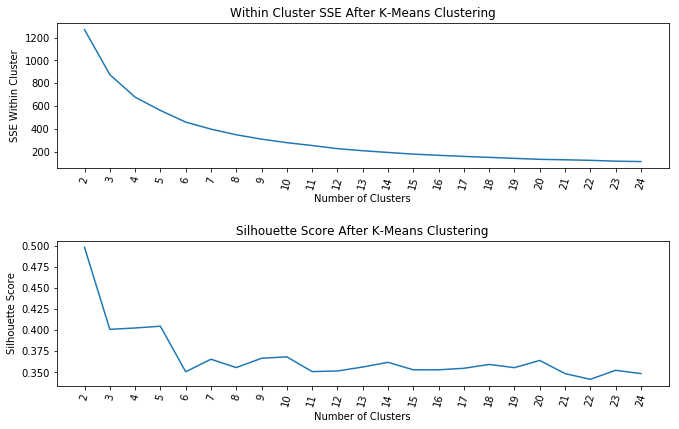

In [20]:
plot_cluster(agg_df3_sub, max_loop=25)

From the second graph, `Silhouette Score After K-Means Clustering`, we can see that there was a steep drop in silhouette score between 5 clusters and 6 clusters. As such, I would use 5 clusters in my K-Means model below.

In [21]:
second_trial= apply_cluster(agg_df3_sub, clusters=5)

clustering performance
-----------------------------------
silhouette score: 0.4
sse withing cluster: 561.0


In [22]:
sub_cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

sub_cluster_perf_df

,cluster,avg_yearly_returns,variance,ticker
0,3,-0.111930,0.107717,129
1,2,0.038041,0.281023,99
2,0,0.081053,0.055844,620
3,1,0.222080,0.124024,225
4,4,0.288640,0.401854,50


To better ascertain the performance of each cluster, I decided to add in Sharpe Ratio as a metric to better evaluate their performance. Using the first day of the year, 5-years daily U.S. yield rates, from https://home.treasury.gov/ as the risk-free rate, I have computed the Sharpe Ratio as such:

$Sharpe\ Ratio = (R_s - R_f) /{SD_s}$

In [41]:
# calculating the average risk free rate over the time period of 2012 - 2018 
us_yield_curve_5years_dict = {"year": [2012, 2013, 2014, 2015, 2016, 2017, 2018],
                         "risk_free_rate": [0.89, 0.76, 1.72, 1.61, 1.73, 1.94, 2.25]}
us_yield_curve_5years_df = pd.DataFrame.from_dict(us_yield_curve_5years_dict)

avg_risk_free_rate = (
    us_yield_curve_5years_df
    .mean()
    [['risk_free_rate']]
    [0]
)

In [24]:
def get_sharpe_ratio_df(df):
    """
    Computing Sharpe Ratio
    """
    df_w_sharpe_ratio = (
        df
        .pipe(lambda x: x.assign(avg_risk_free_rate=avg_risk_free_rate/100))
        .pipe(lambda x: x.assign(std_dev=np.sqrt(x.variance)))
        .pipe(lambda x: x.assign(sharpe_ratio=(x.avg_yearly_returns-x.avg_risk_free_rate)/x.std_dev))
    )

    return df_w_sharpe_ratio

In [42]:
second_trial_w_sharpe_ratio = get_sharpe_ratio_df(second_trial)

In [43]:
def get_transform_df(df_w_sharpe_ratio):
    """
    Transforming dataframe so that I can plot a boxplot of `Returns`, `Variance` and `Sharpe Ratio` for each cluster
    """
    df_yearly_returns = (
        df_w_sharpe_ratio
        [['avg_yearly_returns', 'cluster']]
        .pipe(lambda x: x.assign(type='avg_yearly_returns'))
        .rename(columns={"avg_yearly_returns": "rate"})
    )

    df_variance = (
        df_w_sharpe_ratio
        [['variance', 'cluster']]
        .pipe(lambda x: x.assign(type='variance'))
        .rename(columns={"variance": "rate"})
    )

    df_sharpe_ratio = (
        df_w_sharpe_ratio
        [['sharpe_ratio', 'cluster']]
    )

    df_transform = pd.concat([df_yearly_returns, df_variance], axis=0)

    return df_transform, df_sharpe_ratio

In [44]:
sub_cluster_transform, sub_cluster_sharpe_ratio = get_transform_df(second_trial_w_sharpe_ratio)

In [45]:
def cluster_perf(transform_df, sharpe_ratio_df):
    """
    Plotting boxplot of cluster performance
    """
    _  = plt.figure(figsize=(15,7))

    ax1 = plt.subplot(121)
    _ = sns.boxplot(x='cluster', y='rate', hue='type', data=transform_df)
    _ = plt.title("Distribution of Returns and Variance for each Cluster")

    ax2 = plt.subplot(122)
    _ =sns.boxplot(x='cluster', y='sharpe_ratio', data=sharpe_ratio_df, color='royalblue')
    _ = plt.title("Distribution of Sharpe Ratio for each Cluster")

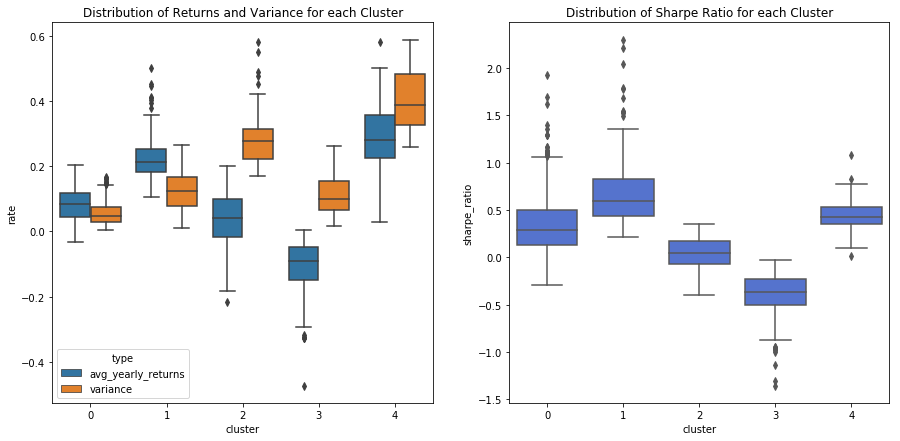

In [46]:
cluster_perf(sub_cluster_transform, sub_cluster_sharpe_ratio)

From the charts above, we can see that cluster `1` has the best sharpe ratio distribution amongst the rest and that their average returns (22.2%) and variance (12%) is still acceptable for my risk appetite. For someone who have a smaller risk appetite, he/she should be looking at cluster `0`, where the sharpe ratio is still fairly decent, along with moderate average returns (8.1%) and variance(5.6%)

As there are still more than 200 stocks in cluster `1` and there are some outliers (outperforming stocks) in that cluster, I would like to take segement it even further so that I can have a smaller group of stocks to research on.

In [47]:
best_sub_cluster = second_trial.query("cluster == 1")

C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


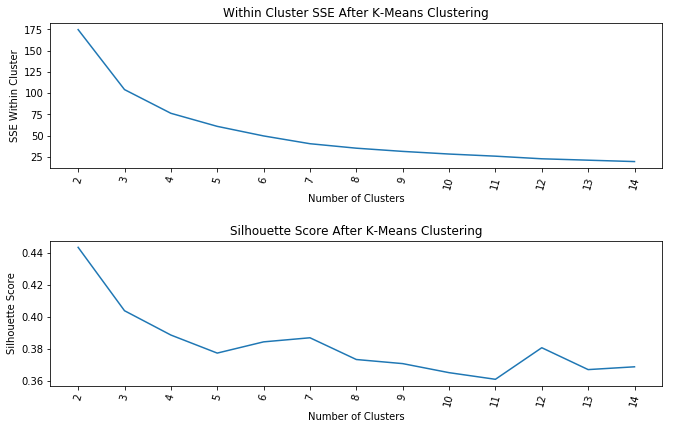

In [48]:
plot_cluster(best_sub_cluster, max_loop=15)

In [59]:
third_trial = apply_cluster(best_sub_cluster, clusters=7)

C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


clustering performance
-----------------------------------
silhouette score: 0.39
sse withing cluster: 40.0


C:\Users\timothy.ong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [60]:
best_sub_cluster_perf = (    
    third_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)
best_sub_cluster_perf

,cluster,avg_yearly_returns,variance,ticker
0,4,0.147380,0.148202,40
1,2,0.196281,0.072204,57
2,5,0.200090,0.207889,30
3,1,0.238052,0.140600,36
4,0,0.259938,0.050189,36
5,6,0.308919,0.186079,18
6,3,0.424229,0.175889,8


In [61]:
third_trial_w_sharpe_ratio = get_sharpe_ratio_df(third_trial)

In [62]:
best_sub_cluster_transform, best_sub_cluster_sharpe_ratio = get_transform_df(third_trial_w_sharpe_ratio)

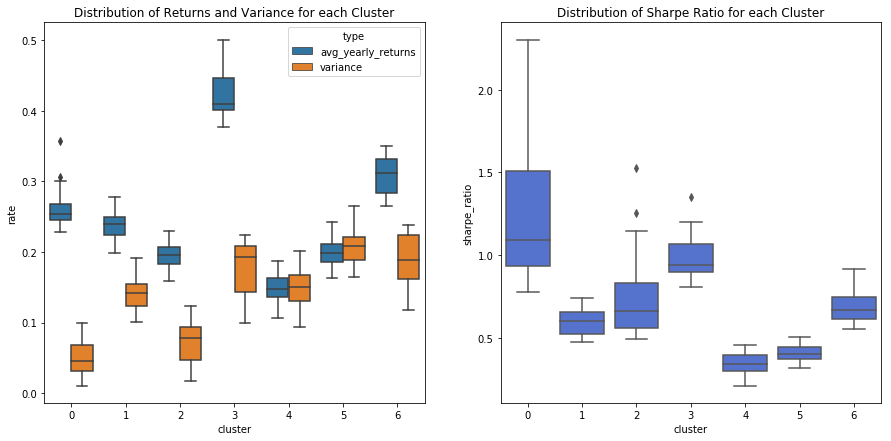

In [63]:
cluster_perf(best_sub_cluster_transform, best_sub_cluster_sharpe_ratio)

We can see that cluster `0` produces the best sharpe ratio and a very impressive average returns of 26% and variance of 5%. This group of 36 stocks definitely deserve my attention to conduct a proper equity research.

# Conclusion